Proyecto de Procesado de Datos

In [2]:
#Importamos librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns

df = pd.read_csv("/workspaces/Data-Preprocessing-Project-Vicente-Polo/data/raw/AB_NYC_2019.csv").iloc[:,1:]

pd.set_option('display.max_columns', None)

df.head()


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Revisión inicial del contenido de DataFrame

In [ ]:
df.describe

<bound method NDFrame.describe of                                                     name   host_id  \
0                     Clean & quiet apt home by the park      2787   
1                                  Skylit Midtown Castle      2845   
2                    THE VILLAGE OF HARLEM....NEW YORK !      4632   
3                        Cozy Entire Floor of Brownstone      4869   
4       Entire Apt: Spacious Studio/Loft by central park      7192   
...                                                  ...       ...   
48890    Charming one bedroom - newly renovated rowhouse   8232441   
48891      Affordable room in Bushwick/East Williamsburg   6570630   
48892            Sunny Studio at Historical Neighborhood  23492952   
48893               43rd St. Time Square-cozy single bed  30985759   
48894  Trendy duplex in the very heart of Hell's Kitchen  68119814   

           host_name neighbourhood_group       neighbourhood  latitude  \
0               John            Brooklyn          K

Comprobamos si hay columnas con valores constantes para eliminarlas

In [4]:
n_unicos = df.nunique()

n_unicos

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

Comprobamos el tipo de las columnas para establecer una idea de las categóricas

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

Revisamos que no hay duplicados

In [6]:
df.duplicated().sum()

np.int64(0)

Comprobamos las columnas con datos faltantes

<Axes: >

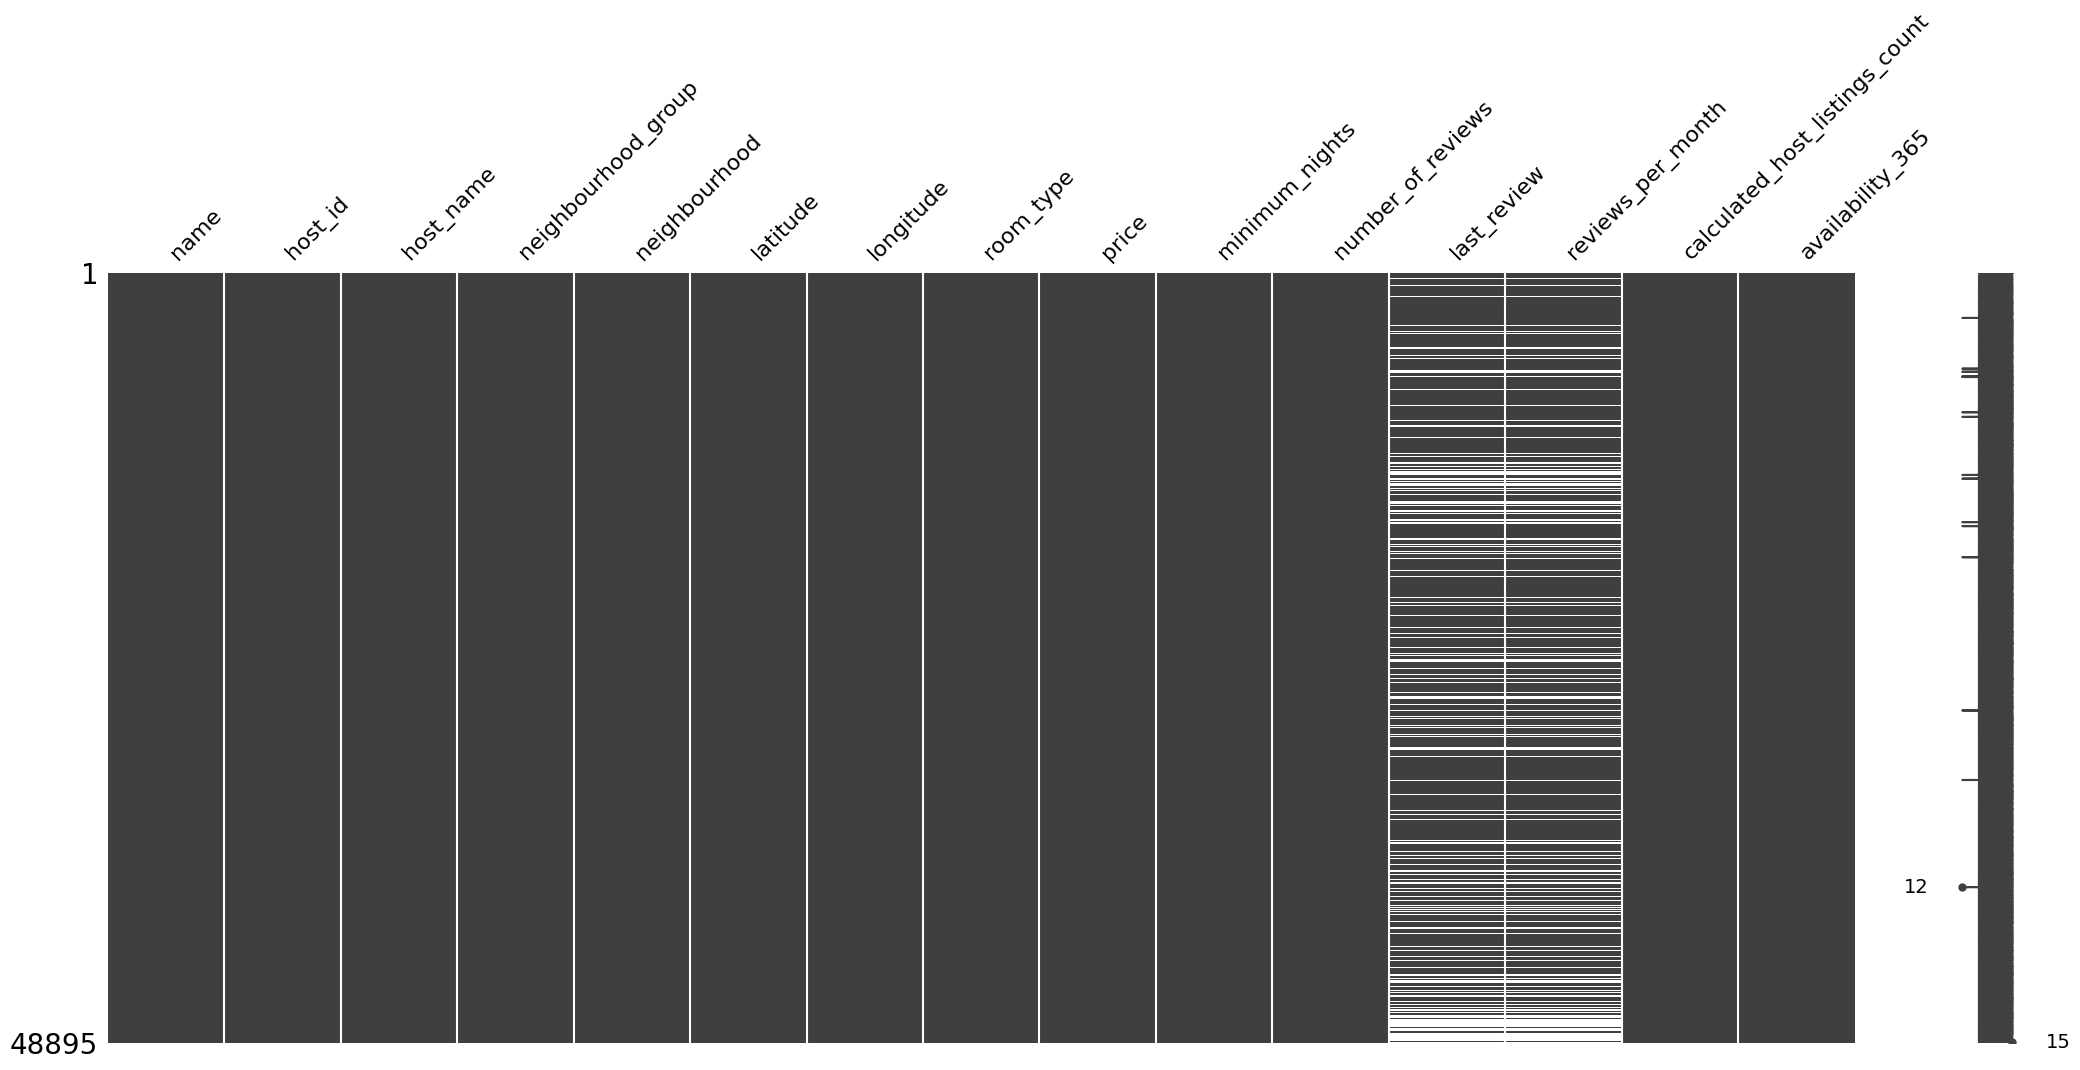

In [4]:
msno.matrix(df)

In [8]:
# Comprobamos numéricamente el porcentaje de valores faltantes en las diferentes columnas
df.isnull().mean()*100


name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

Procedemos a comprobar la relación entre last_review y reviews_per_month para tratar de explicar por qué tienen un porcentaje idéntico

In [9]:
# Convertir la columna last_review a datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Comprobar los valores después de la conversión
print(df['last_review'].dtypes)

# Convertir last_review a días desde el último review (si aplica)
df['last_review_numeric'] = (pd.to_datetime('today') - df['last_review']).dt.days

# Correlación entre last_review y reviews_per_month
correlation = df[['last_review_numeric', 'reviews_per_month']].corr()
print(correlation)

datetime64[ns]
                     last_review_numeric  reviews_per_month
last_review_numeric             1.000000          -0.441489
reviews_per_month              -0.441489           1.000000


A medida que aumentan los días desde la última reseña el número de reseñas por mes disminuye. Por lo que deducimos que cuanto más antigua sea la última reseña, menor será la actividad en términos de reseñas recientes.

Lo mostramos en un gráfico

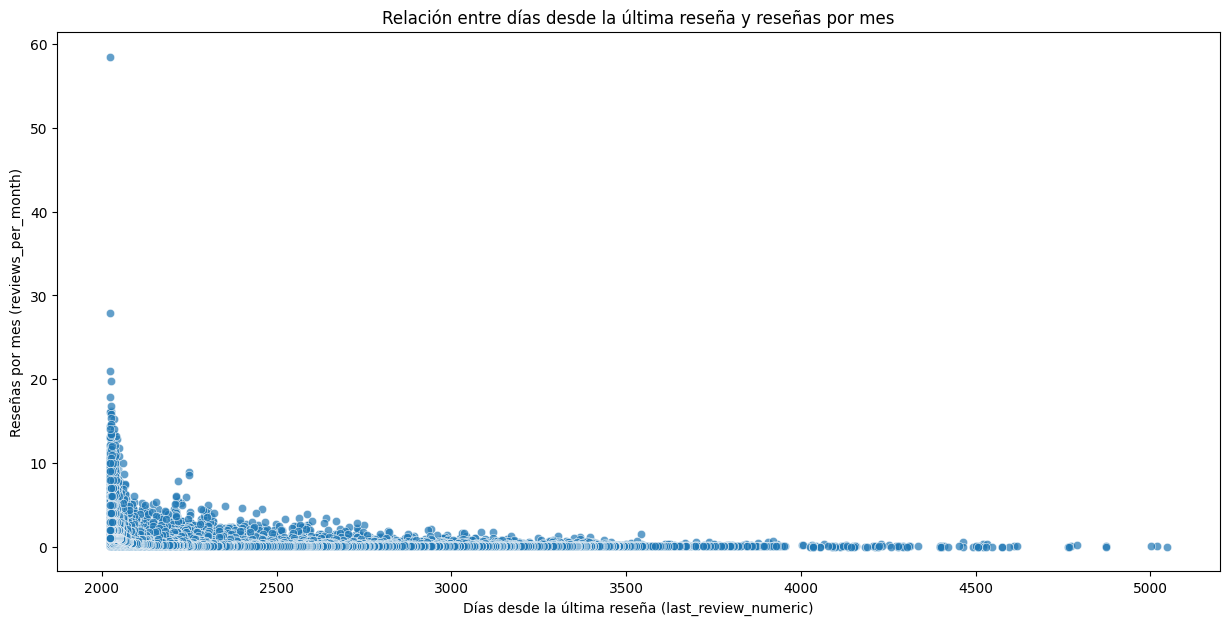

In [15]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='last_review_numeric', y='reviews_per_month', data=df, alpha=0.7)
plt.title('Relación entre días desde la última reseña y reseñas por mes')
plt.xlabel('Días desde la última reseña (last_review_numeric)')
plt.ylabel('Reseñas por mes (reviews_per_month)')
plt.show()


Mostramos un histograma con los precios 

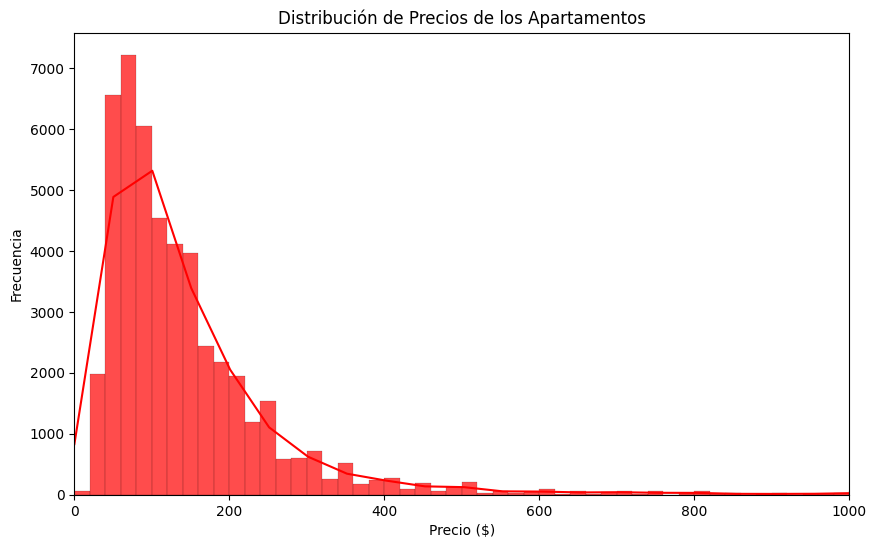

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=500, kde=True, color='red', alpha=0.7)
plt.title('Distribución de Precios de los Apartamentos')
plt.xlabel('Precio ($)')
plt.ylabel('Frecuencia')
plt.xlim(0, 1000)  # Limitar el rango de precios para mayor claridad
plt.show()


Observamos como los valores más repetidos se encuentran entre 50 y 200 aproximadamente (Estamos hablando del precio por noche en aribnb, lo cual no es descabellado)

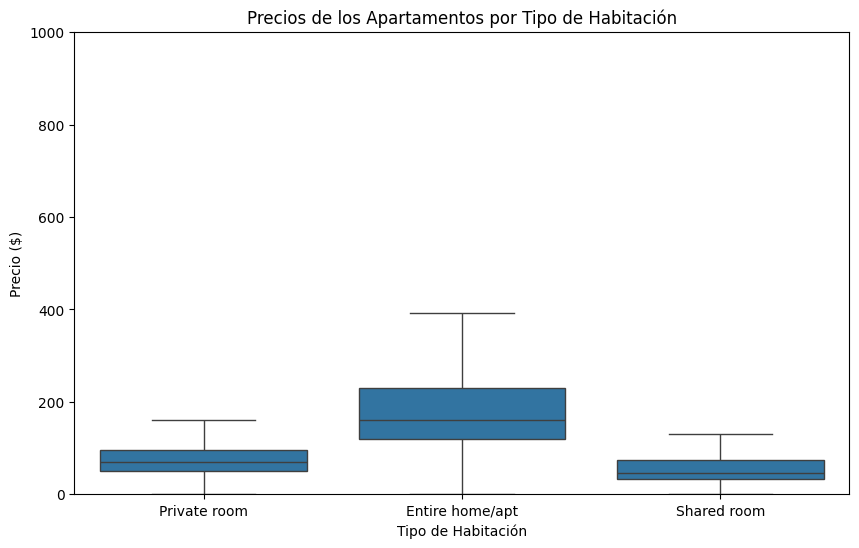

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df, showfliers=False)
plt.title('Precios de los Apartamentos por Tipo de Habitación')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Precio ($)')
plt.ylim(0, 1000)  # Limitar los precios para evitar valores extremos
plt.show()


Los precios para una habitación (ya sea compartida o privada) son lógicamente inferiores al precio de un apartamento entero

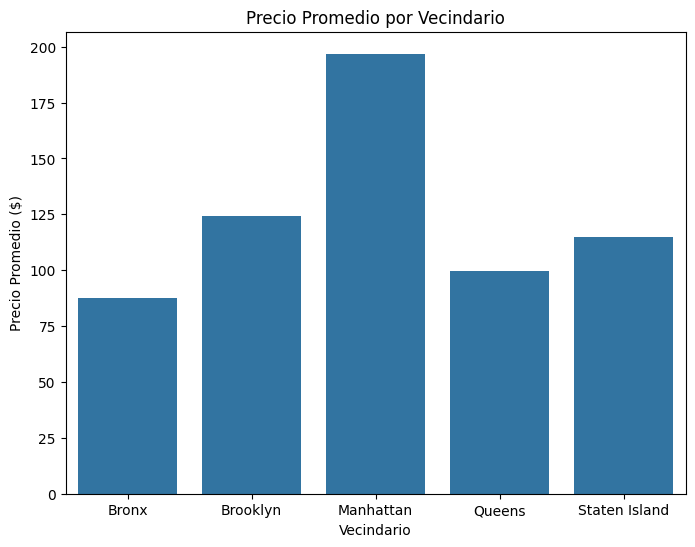

In [24]:

price_by_neighbourhood = df.groupby('neighbourhood_group')['price'].mean().reset_index()


plt.figure(figsize=(8, 6))
sns.barplot(x='neighbourhood_group', y='price', data=price_by_neighbourhood)
plt.title('Precio Promedio por Vecindario')
plt.xlabel('Vecindario')
plt.ylabel('Precio Promedio ($)')
plt.show()

Podemos comprobar que alquilar en Manhattan, Brooklyn o Staten Island es mas caro que en Bronx o Queens

Respecto al 7.5% de valores faltantes entre las columnas name y host_name, procedemos a comprobar: 

In [31]:
#Identificamos filas con valores faltantes
complete_rows = df.dropna(subset=['name', 'host_name'])
missing_name_host = df[df[['name', 'host_name']].isnull().any(axis=1)]
print(missing_name_host)


                                                    name    host_id host_name  \
360                                            Bienvenue     526653       NaN   
2700                             Cozy Studio in Flatbush    7779204       NaN   
2854                                                 NaN    6676776     Peter   
3703                                                 NaN   11395220      Anna   
5745     SPRING in the City!! Zen-Style Tranquil Bedroom     919218       NaN   
5775                                                 NaN   20700823     Jesse   
5975                                                 NaN   22686810   Michaël   
6075                  Charming Room in Prospect Heights!   23077718       NaN   
6269                                                 NaN   21600904     Lucie   
6567                                                 NaN    1832442  Carolina   
6582                 Luxurious, best location, spa inc'l   24576978       NaN   
6605                        

Comprobamos las posibles relaciones con los valores faltantes

In [32]:
print(missing_name_host['neighbourhood_group'].value_counts())
print(missing_name_host['room_type'].value_counts())

neighbourhood_group
Manhattan    18
Brooklyn     15
Queens        2
Bronx         2
Name: count, dtype: int64
room_type
Private room       20
Entire home/apt    16
Shared room         1
Name: count, dtype: int64


- Por vecindario: Manhattan y Brooklyn tienen la mayoría de los valores faltantes lo cual es comprensible dado que también son los barrios que presentan un mayor número de registros. 

- Por tipo de habitación: Se da un mayor número (20) en las habitaciones privadas, quizá los propietarios de dichas habitaciones son mas propensos a no querer rellenar sus datos. A pesar de que también hay un numero similar (16) en los apartamentos, en lo que respecta a la proporcion de apartamentos (mucho mayor) no es tan significativo



In [33]:
print("Precio promedio (faltantes):", missing_name_host['price'].mean())
print("Precio promedio (completos):", complete_rows['price'].mean())

Precio promedio (faltantes): 126.8108108108108
Precio promedio (completos): 152.74030864955586


Podemos sacar la conclusión de que aquellos apartamentos/habitaciones con todos sus datos tienen una diferencia notable en precio con aquellos que no completan sus datos. 


# Volviendo al tema de la limpieza de datos, eliminamos los datos correspondientes a review y tambien las columnas name y host_name



In [34]:
#Eliminamos columnas con 20% de nulos, así como name y host_name
df.drop(["name", "host_name", "last_review", "reviews_per_month"],axis=1,inplace=True)


In [35]:
#Procedemos a comprobar si aún quedan datos faltantes

df.isnull().any(axis=1).mean()*100

np.float64(20.55833929849678)

# Identificar correlaciones mediante heatmap

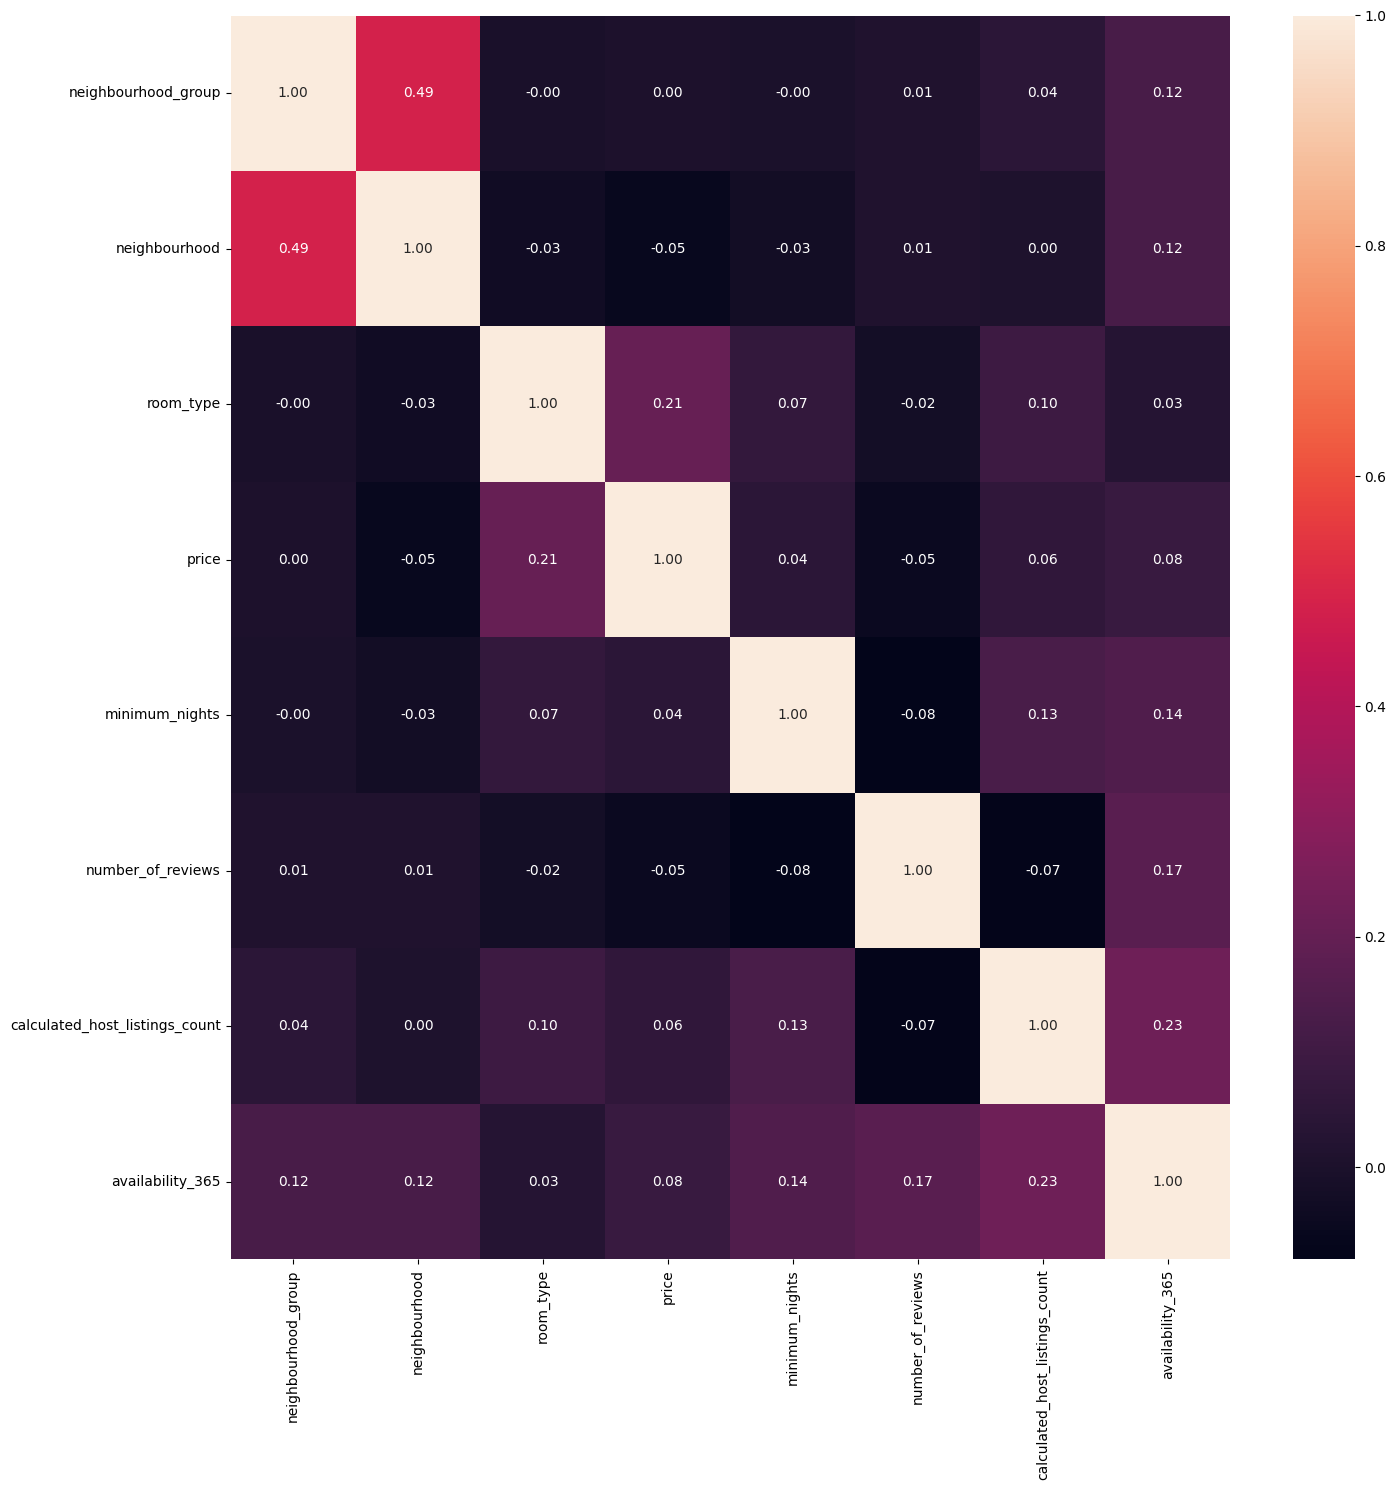

In [13]:
df["room_type"] = pd.factorize(df["room_type"])[0]
df["neighbourhood_group"] = pd.factorize(df["neighbourhood_group"])[0]
df["neighbourhood"] = pd.factorize(df["neighbourhood"])[0]

fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(df[["neighbourhood_group", "neighbourhood", "room_type", "price", "minimum_nights",	
                        "number_of_reviews", "calculated_host_listings_count", "availability_365"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

# Draw Plot
plt.show()

Neighbourhood y neighbourhood_group, tienen una correlación evidente debido a su factorización. Esto es esperado, ya que agrupan barrios y subdivisiones relacionadas

# Identificar observaciones influyentes

In [14]:
# Separamos las variables independientes de la dependiente
X = df.drop(['price'], axis=1)
y = df['price']

# Ajusta un modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

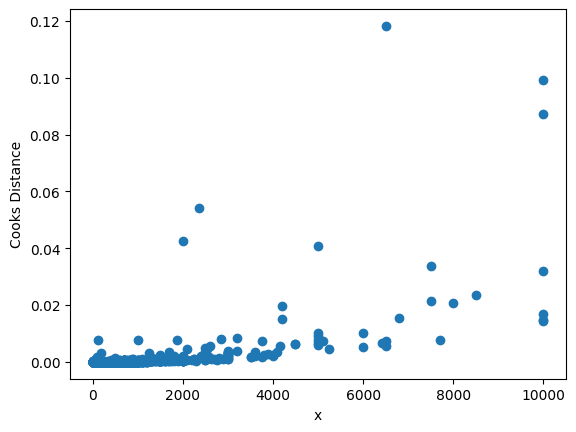

In [15]:
plt.scatter(df.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [16]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

# Viviendas por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

700

Me muestra los valores por encima de 0.05

In [20]:

ind_cook = np.where(cooks_distance[0] > 0.05)[0]
print(f"Observaciones con distancia de Cook > 0.05: {len(ind_cook)}") 

# Mostrar los índices si son pocos
if len(ind_cook) > 0:
    print(f"Índices con distancia de Cook > 0.05: {ind_cook}")

Observaciones con distancia de Cook > 0.05: 4
Índices con distancia de Cook > 0.05: [ 9151 12342 17811 48043]


Eliminamos los valores que exceden el punto de corte sugerido

In [18]:
df = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

# Definimos X e Y para dividir el data set entre train y test

In [19]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)